In [1]:
#%matplotlib notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import lmfit
import pprint
import os
import mplcursors


aslognorm = lambda data: 20*np.log10(np.abs(data)/np.abs(data).max())
dirpath = os.getcwd()
print("current directory is : " + dirpath)
foldername = os.path.basename(dirpath)
print("Directory name is : " + foldername)

ModuleNotFoundError: No module named 'mplcursors'

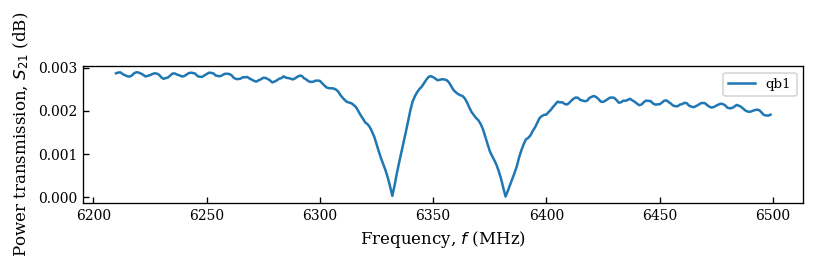

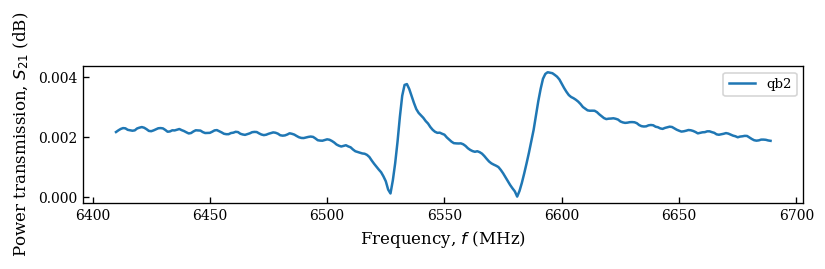

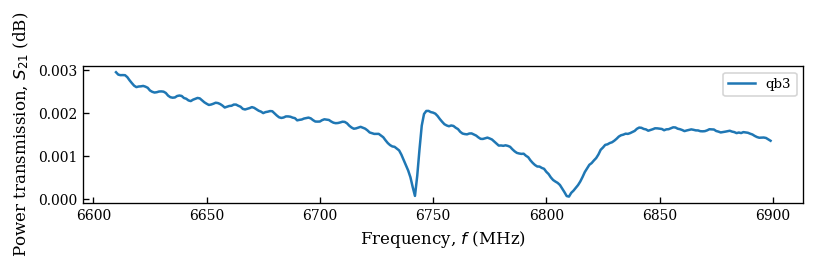

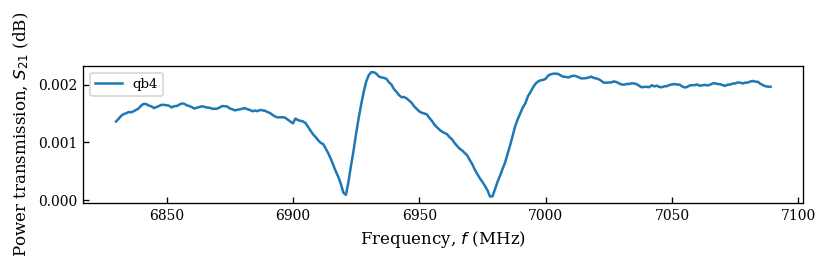

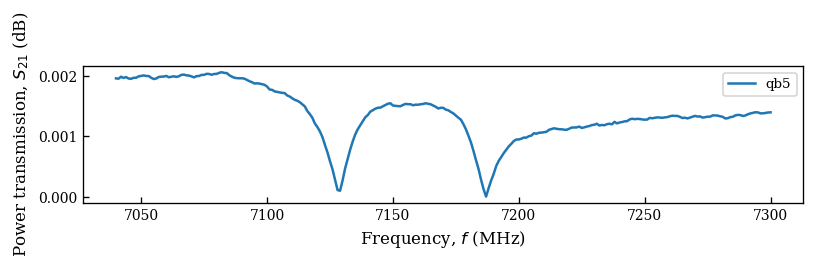

In [19]:
dataset_all = {
    'qb1': (f1, s1),
    'qb2': (f1, s1),
    'qb3': (f1, s1),
    'qb4': (f1, s1),
    'qb5': (f1, s1)    
}

datarange = {
    'qb1': (6.25e9, 6.46e9),
    'qb2': (6.45e9, 6.65e9),
    'qb3': (6.65e9,6.86e9),
    'qb4': (6.87e9, 7.05e9),
    'qb5': (7.08e9, 7.3e9),
}

datarange = {qb: (r[0] - 40e6, r[1] + 40e6) for qb, r in datarange.items()}
filterdatax = lambda f, s, r: (f[(f >= r[0])*(f < r[1])], s[(f >= r[0])*(f < r[1])])
dataset = {qb: filterdatax(*dataset_all[qb], datarange[qb]) for qb in dataset_all}

# for qb in ['qb3', 'qb6', 'qb7']:
for qb in ['qb1','qb2','qb3','qb4', 'qb5']:
    f, s = dataset[qb]
    plt.plot(f/1e6, np.abs(s), label=qb)
    plt.xlabel('Frequency, $f$ (MHz)')
    plt.ylabel('Power transmission, $S_{21}$ (dB)')
    plt.legend()
    plt.show()

In [20]:
def fit_and_plot_complex(freq, s21, plotfit=True, plotguess=True, label=None, plot_filename=None, **guessvals):
    def s21func(x, A, phi, kP, gR, wR, wP, J, tau, k, phi0): 
        y = (A + k*(x-np.mean(x)))*np.exp(1j*tau*x + 1j*phi0)*(np.cos(phi) - np.exp(1j*phi)*kP*(gR-2j*(x-wR))/(4*J*J+(kP-2j*(x-wP))*(gR-2j*(x-wR))))
        return np.concatenate((np.real(y), np.imag(y)))
    model = lmfit.Model(s21func)
    def_guessvals = dict(
        A=0.5,
        phi=-0.6,
        kP=50.8,
        gR=0.5,
        wR=np.mean(freq),
        wP=np.mean(freq),
        J=12,
        tau=np.median(np.diff(np.angle(s21)))/np.median(np.diff(freq)),
        k=0,
        phi0=0,
    )
    def_guessvals.update(guessvals)
    pars = model.make_params(**def_guessvals)
    pars['kP'].min = 0
    pars['gR'].min = 0
    pars['J'].min = 0
    pars['wP'].min = freq.min()
    pars['wR'].min = freq.min()
    pars['wP'].max = freq.max()
    pars['wR'].max = freq.max()
    fit = model.fit(np.concatenate((np.real(s21), np.imag(s21))), x=freq, params=pars)
    s21fit = fit.best_fit[:len(freq)] + 1j*fit.best_fit[len(freq):]
    s21guess = s21func(freq, **def_guessvals)
    s21guess = s21guess[:len(freq)] + 1j*s21guess[len(freq):]
    
    plt.subplot(121)
    plt.plot(freq, np.abs(s21), label=label)
    if plotfit: plt.plot(freq, np.abs(s21fit))
    if plotguess: plt.plot(freq, np.abs(s21guess))
    plt.xlabel('Frequency, $f$ (MHz)')
    plt.ylabel('Transmission amplitude, $|S_{21}|$')
    if label is not None: plt.legend()
    plt.subplot(122)
    plt.plot(freq, np.angle(s21))
    if plotfit: plt.plot(freq, np.angle(s21fit), 'r-',linewidth=1, label='Lorentzian fit')
    if plotguess: plt.plot(freq, np.angle(s21guess),'k--',  linewidth=2, label='Simulation')
    plt.xlabel('Frequency, $f$ (MHz)')
    plt.ylabel('Transmission angle, $\\mathrm{arg}(S_{21})$')
    
    plt.gcf().set_size_inches(9,3)
    if plot_filename is not None: plt.savefig(plot_filename, bbox_inches='tight')
    plt.show()

    
    return fit, s21fit

def fit_and_plot_abs(freq, s21, plotfit=True, plotguess=True, label=None, plot_filename=True, **guessvals):
    def s21func(x, A, phi, kP, gR, wR, wP, J, k): 
        y = (A + k*(x-np.mean(x)))*np.abs(np.cos(phi) - np.exp(1j*phi)*kP*(gR-2j*(x-wR))/(4*J*J+(kP-2j*(x-wP))*(gR-2j*(x-wR))))
        return y
    model = lmfit.Model(s21func)
    def_guessvals = dict(
        A=0.5,
        phi=-0.6,
        kP=50.8,
        gR=0.5,
        wR=np.mean(freq),
        wP=np.mean(freq),
        J=12,
        k=0,
    )
    def_guessvals.update(guessvals)
    pars = model.make_params(**def_guessvals)
    pars['kP'].min = 0
    pars['gR'].min = 0
    pars['J'].min = 0
    pars['wP'].min = freq.min()
    pars['wR'].min = freq.min()
    pars['wP'].max = freq.max()
    pars['wR'].max = freq.max()
    fit = model.fit(np.abs(s21), x=freq, params=pars)
    s21fit = fit.best_fit
    s21guess = s21func(freq, **def_guessvals)
    
    plt.plot(freq, np.abs(s21),'k--',  linewidth=1.2, label=label)
    if plotfit: plt.plot(freq,s21fit, 'r-',linewidth=0.8, label='Fit')
    if plotguess: plt.plot(freq, s21guess,'k--',  linewidth=2, label='Simulation')
    plt.xlabel('Frequency, $f$ [MHz]')
    plt.ylabel('Normalized transmission\n amplitude, $|S_{21}|/ \\mathrm{max}(|S_{21}|)$')
    if label is not None: plt.legend()
#     plt.gcf().set_size_inches(4.5,3)
    if plot_filename is not None: plt.savefig(plot_filename+'.pdf', bbox_inches='tight')
    plt.show()

    
    return fit, s21fit




qb1


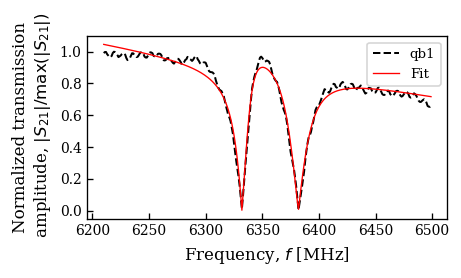

{'A': 0.897003146214816,
 'J': 24.595457174456307,
 'gR': 7.826634429441981e-08,
 'k': -0.0012204377569202914,
 'kP': 45.996153302511466,
 'phi': 25.20509523220074,
 'wP': 6362.674570135049,
 'wR': 6352.893801926385}



qb2


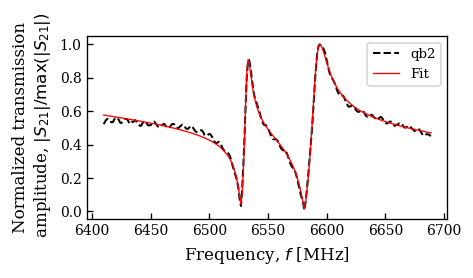

{'A': 1.0948268079025554,
 'J': 26.10632788507718,
 'gR': 1.5792655956547912,
 'k': -0.0016336673494026456,
 'kP': 15.799691252655812,
 'phi': 26.203111561203958,
 'wP': 6575.408256361599,
 'wR': 6547.120103148458}



qb3


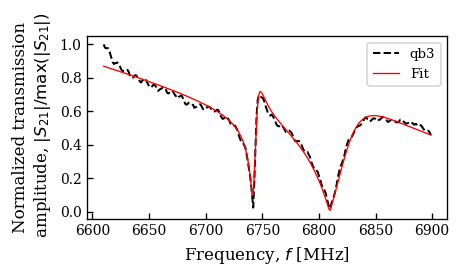

{'A': 0.7968520186146557,
 'J': 25.69023635413778,
 'gR': 1.608208250150303,
 'k': -0.002243563840459053,
 'kP': 51.30579714756385,
 'phi': 0.5546995650807829,
 'wP': 6813.774400504515,
 'wR': 6753.288848682929}



qb4


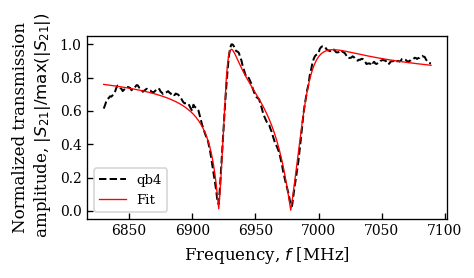

{'A': 0.9817350292160646,
 'J': 27.308879697384498,
 'gR': 0.382656131051869,
 'k': -0.00025072792514287286,
 'kP': 40.21119581401525,
 'phi': 0.5754134641127214,
 'wP': 6970.731366143309,
 'wR': 6941.286228655718}



qb5


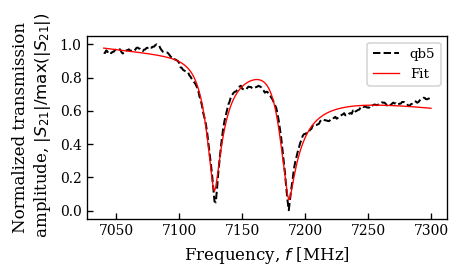

{'A': 0.8371598275725408,
 'J': 29.333607604481973,
 'gR': 5.20631451445286,
 'k': -0.0011423423709813207,
 'kP': 41.562763981244,
 'phi': 24.81615894532087,
 'wP': 7155.161393283461,
 'wR': 7153.119560643076}


In [21]:

my_params = {
'figure.dpi':  120,
'figure.figsize': [4,2], # [4,3]
'figure.subplot.left' : 0.15,
'figure.subplot.right'      : 0.9,
'figure.subplot.bottom'     : 0.12,
'axes.titlesize'    : 'medium',
'axes.labelsize'    : 10.0 ,
'xtick.direction' : 'in',
'ytick.direction' : 'in',
'ytick.labelsize'   :'small',
'xtick.labelsize'   :'small',
'legend.fontsize'   : 8,  #small,
'legend.loc'        : 'best',
'font.size'         : 10.0,
'font.family'       : 'serif',
'text.usetex' : False,    # if you have latex
}

guessvals = {
    'qb1': {'A': 1,
            'J': 25,
            'gR': 1,
            'k': 0.1,
            'kP': 50,
            'phi': 25,
            'wP': 6350,
            'wR': 6400},
    'qb2': {'A': 1,
            'J': 25,
            'gR': 10,
            'k': 0.1,
            'kP': 50,
            'phi': 25,
            'wP': 6550,
            'wR': 6575},
    'qb3': {'A': 1,
            'J': 25,
            'gR':10,
            'k': 0.1,
            'kP': 50,
            'phi': 0.1,
            'wP': 6725,
            'wR': 6795},
    'qb4': {'A': 1,
            'J': 25,
            'gR': 10,
            'k': 5,
            'kP': 50,
            'phi': 0.1,
            'wP': 6925,
            'wR': 6975},
    'qb5': {'A': 1,
            'J': 25,
            'gR': 0.3,
            'k': 5,
            'kP': 50,
            'phi': 25,
            'wP': 7150,
            'wR': 7205},
    
}

datatransform = lambda f, s: (f/1e6, s/np.abs(s).max())

bestvals = {}



plt.rcParams.update(my_params)


for qb in dataset:
    print(f'\n\n\n{qb}')
    fit, s21fit = fit_and_plot_abs(*datatransform(*dataset[qb]), **guessvals[qb], plotguess=False, label=qb, plot_filename=qb+'.png')
    
    pprint.pprint(fit.best_values)
    bestvals[qb] = fit.best_values

In [22]:
print('   ', end='  ')
for par in ['wR', 'wP', 'kP', 'J']:
    print('{: <7}'.format(par), end='')
print('{: <7}'.format('Delta'), end='')
print('{: <7}'.format('kEff'), end='')
#print('{: <7}'.format('kEffPlus'), end='')
print()
for qb, vals in bestvals.items():
    print(qb, end=': ')
    for par in ['wR', 'wP', 'kP', 'J']:
        print('{: <7.1f}'.format(vals[par]), end='')
    print('{: <7.0f}'.format(vals['wR'] - vals['wP']), end='')
    kEff = (lambda kP, wP, wR, J, **kwargs: 0.5*(kP - np.real(np.sqrt((kP+2j*(wP-wR))**2 - 16*J**2))))(**vals)
    #kEffP = (lambda kP, wP, wR, J, **kwargs: 0.5*(kP - np.real(np.sqrt((kP+2j*(wP-wR-50))**2 - 16*J**2))))(**vals)
    print('{: <7.1f}'.format(kEff), end='')
    #print('{: <7.0f}'.format(kEffP), end='')
#     t1lim = (lambda kP, J, g=130, delta=700, **kwargs: delta**4/(2*np.pi*g**2*J**2*kP))(**vals)
#     print('{: <7.0f}'.format(t1lim), end='')
    print()
    

     wR     wP     kP     J      Delta  kEff   
qb1: 6352.9 6362.7 46.0   24.6   -10    18.0   
qb2: 6547.1 6575.4 15.8   26.1   -28    4.1    
qb3: 6753.3 6813.8 51.3   25.7   -60    5.7    
qb4: 6941.3 6970.7 40.2   27.3   -29    10.2   
qb5: 7153.1 7155.2 41.6   29.3   -2     20.0   
